In [7]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [8]:
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"]

## Creating a function to do the data wrangling for all the data sets

In [9]:
def wrangle(file_path):
    df = pd.read_csv(file_path, # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python" 
    )
   

    # computing the zenith angle in radians
    df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
    df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

    # theta radians in degrees
    df['theta'] = np.rad2deg(df['theta_rad'])


    return df


In [10]:
chyulu = wrangle("chyulu_1500_E2_T300.shw")
chyulu.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,13,0.031282,0.025032,0.750592,-30016.70,-103932.00,37.6692,1,703,26.2323,68.224,71.280,0.751661,0.053327,3.055406
1,13,0.470253,-0.134478,0.546199,5660.52,-4804.10,951.6750,2,703,38.6877,17.003,-89.931,0.733182,0.730305,41.843414
2,13,-0.095349,0.164322,0.301931,-8722.89,-5923.20,947.2770,3,703,148.4800,40.463,77.817,0.356729,0.561630,32.179026
3,6,0.239349,2.100790,2.296850,-3053.40,-1505.76,955.0910,3,703,148.4800,40.463,77.817,3.121879,0.744057,42.631329
4,13,0.018933,-0.030928,0.768693,4107.03,-15106.30,936.7710,4,703,17.6367,24.473,128.604,0.769548,0.047140,2.700930


In [11]:
lyon = wrangle("lyon_1500_E2_T300.shw")
lyon.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,13,0.218794,0.235932,0.415023,52913.700,-58161.600,470.862,1,703,55.8797,72.538,155.057,0.525146,0.659499,37.786489
1,14,0.207665,-0.150037,0.218522,2001.540,-1118.110,955.588,2,703,94.2717,9.859,63.925,0.336731,0.864591,49.537413
2,13,0.210676,1.006530,1.181860,1752.410,-616.471,955.729,2,703,94.2717,9.859,63.925,1.566614,0.716051,41.026682
3,6,0.158690,0.479482,2.098490,-360.194,-662.494,955.955,2,703,94.2717,9.859,63.925,2.158413,0.236186,13.532446
4,13,0.024366,-0.083097,0.380444,-589.417,-1528.600,955.789,2,703,94.2717,9.859,63.925,0.390175,0.223804,12.823006


In [12]:
# Comparing the unique values in both
print(f"Total showers id in chyulu: {chyulu["shower_id"].nunique()}")
print()
print(f"Total showers id in Lyon: {lyon["shower_id"].nunique()}")

Total showers id in chyulu: 47848

Total showers id in Lyon: 47403


In [13]:
# subsetting the data for only muons and resetting the index
muons_lyon = (lyon["CorsikaId"] == 6)
lyon = lyon[muons_lyon].reset_index()

muons_chyulu = (chyulu["CorsikaId"] == 6)
chyulu = chyulu[muons_chyulu].reset_index()

Comparing the graphs

In [14]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [15]:
# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)
 # binning the zenith angle
bins = np.arange(0, 91, 10)

Fitted I0 with n=3: 31.070 (in arbitrary units)
Fitted I0 with n=3: 32.681 (in arbitrary units)


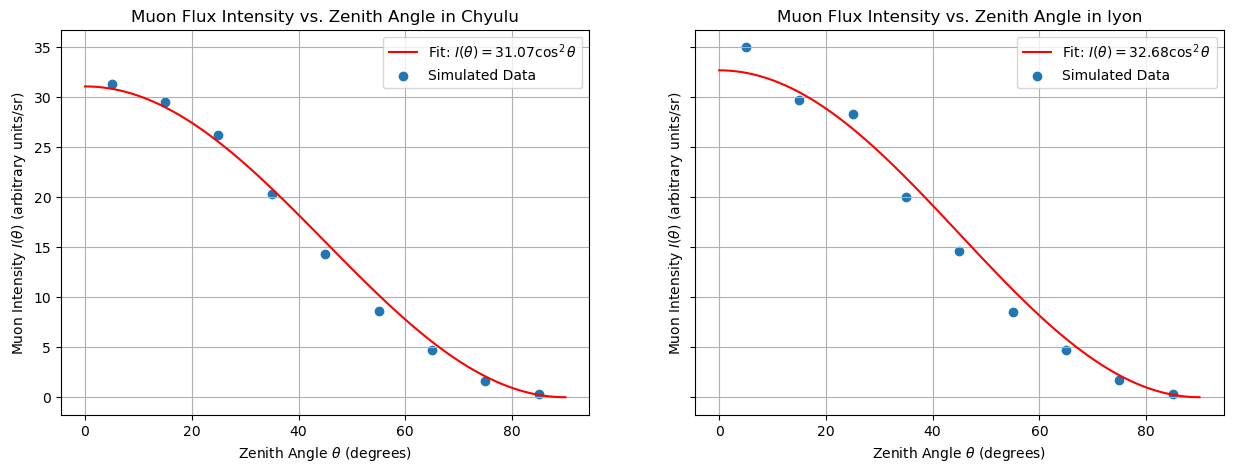

In [16]:
# creating the 3 plots in one row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=True)

# zenith angles for chyulu
counts, bin_edges = np.histogram(chyulu['theta'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# calculating solid angle
bin_edges_rad = np.deg2rad(bin_edges) 
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

# calculating flux intensity (input how long the simulation was running)
time = float(input("How long did the simulation run in Chyulu(s): "))
flux_intensity = counts / time / solid_angles



# fitting the binned data
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)


#plotting the curve on the same plot as 
axes[0].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[0].scatter(bin_centers, flux_intensity, label='Simulated Data')


# plotting the graph
axes[0].set_title('Muon Flux Intensity vs. Zenith Angle in Chyulu')
axes[0].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[0].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[0].legend()
axes[0].grid(True)

# ------------------------------------------------------------------------------

# zenith angles for lyon
counts_chyulu, bin_edges_chyulu = np.histogram(lyon['theta'], bins=bins)
bin_centers_chyulu = (bin_edges_chyulu[:-1] + bin_edges_chyulu[1:]) / 2.0

# calculating solid angle
bin_edges_rad_c = np.deg2rad(bin_edges_chyulu) 
solid_angles_chyulu = 2 * np.pi * (np.cos(bin_edges_rad_c[:-1]) - np.cos(bin_edges_rad_c[1:]))

# calculating flux intensity (input how long the simulation was running)
time_chyulu = float(input("How long did the simulation run in lyon(s): "))
flux_intensity_chyulu = counts_chyulu / time_chyulu / solid_angles_chyulu

# fitting the binned data
try:
    popt_chyulu, pcov_chyulu = curve_fit(cos_squared_model, bin_centers_chyulu, flux_intensity_chyulu, p0=[1.0])
    I0_fit_chyulu = popt_chyulu[0]
    print(f"Fitted I0 with n=3: {I0_fit_chyulu:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit_chyulu = 1.0 # Default value if fit fails


# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit_chyulu)


#plotting the curve on the same plot as 
axes[1].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit_chyulu:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[1].scatter(bin_centers_chyulu, flux_intensity_chyulu, label='Simulated Data')


# plotting the graph
axes[1].set_title('Muon Flux Intensity vs. Zenith Angle in lyon')
axes[1].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[1].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[1].legend()
axes[1].grid(True)

# Print all graphs
plt.tight_layout
plt.show()

The difference in Muons in Chyulu and Lyon

In [17]:
lyon.columns

Index(['index', 'CorsikaId', 'px', 'py', 'pz', 'xprime', 'yprime', 't',
       'shower_id', 'prm_id', 'prm_energy', 'prm_theta', 'prm_phi', 'p',
       'theta_rad', 'theta'],
      dtype='object')

In [18]:
print("--Lyon 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_lyon = lyon["CorsikaId"].groupby(lyon["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_lyon = len(lyon)
print(f"Total Muon Distribution {muon_distribution_lyon} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_lyon}")

--Lyon 1500m E2 Time 300 secs-- 

Total Muon Distribution 18999 

Number  of unique shower ids in 11964

 Top ten shower ids in lyon 
 shower_id
3726     376
7853     137
34507    101
35898     97
470       84
43897     79
910       66
24197     52
1060      49
30982     44
Name: CorsikaId, dtype: int64


In [19]:
print("--Chyulu 1500m E2 Time 300 secs-- \n")
# groupby
top_shower_id_chyulu = chyulu["CorsikaId"].groupby(chyulu["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_chyulu = len(chyulu)
print(f"Total Muon Distribution {muon_distribution_chyulu} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_chyulu}")

--Chyulu 1500m E2 Time 300 secs-- 

Total Muon Distribution 18558 

Number  of unique shower ids in 11964

 Top ten shower ids in lyon 
 shower_id
35231    98
32090    78
7191     69
576      61
1022     58
42024    48
5546     44
1087     43
813      41
11787    36
Name: CorsikaId, dtype: int64
